In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import hog, corner_harris, corner_subpix, corner_peaks

from pathlib import Path

### PATHS

In [2]:
PROJ_ROOT = Path().resolve().parents[0]

DATA_DIR = PROJ_ROOT / "data"
# RAW_DATA_DIR = DATA_DIR / "raw"
EXTERNAL_DATA_DIR = DATA_DIR / "external"

# MODELS_DIR = PROJ_ROOT / "models/tmp"

In [3]:
# input_path: Path = RAW_DATA_DIR / "cifar-10-batches-py"
data_path: Path = EXTERNAL_DATA_DIR / "processed_dataset.pkl"
# predictions_path: Path = EXTERNAL_DATA_DIR / "test_predictions.csv"
# model_path: Path = MODELS_DIR

### FEATURES AND DATA PROCESSING

In [4]:
def load_data(file_path, encoding=None):
    """
    Load data from a pickle file

    Args:
        file_path: str
    """
    with open(file_path, 'rb') as f:
        if (encoding is not None):
            data = pickle.load(f, encoding=encoding)
        else:
            data = pickle.load(f)
    return data

def save_data(data, file):
    """
    Save data to a pickle file

    Args:
        data: any
        file: str
    """
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def to_image(img_flat):
    """
    Convert a flattened image to a 3D image

    Args:
        img_flat: np.ndarray
    """
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

def contrast_images(images):
    """
    Compute the contrast of all images

    Args:
        images: np.ndarray
    """
    enhanced_images = []
    for image in images:
        enhanced_images.append(contrast(image))

    return np.array(enhanced_images)

def contrast(image):
    """
    Compute the contrast of an image

    Args:
        image: (32, 32, 3) shape image
    """
    image = image.astype(np.uint8)
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return enhanced_img

def extract_hog_features(images):
    """
    Extract HOG features from a list of images

    Args:
        images: np.ndarray
    """
    hog_features = []

    for image in images:
        gray_image = rgb2gray(image).astype(np.uint8)
        # hog_image_rescaled = exposure.rescale_intensity(gray_image, in_range=(0, 10))
        feature, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')
        # feature, hog_image = hog(hog_image_rescaled, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')
        hog_features.append(feature)

    return np.array(hog_features)

def extract_sift_features(images):
    """
    Extract SIFT features from a list of images

    Args:
        images: np.ndarray
    """
    sift = cv2.SIFT_create()
    sift_features = []

    for image in images:
        gray_image = rgb2gray(image).astype(np.uint8)
        # print(image.shape, gray_image.shape, image.dtype, gray_image.dtype)
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        if descriptors is None:
            sift_features.append(np.zeros((128,)))
        else:
            sift_features.append(descriptors.flatten())
    
    return np.array(sift_features)

### TRAINING & EVALUATING

In [5]:
data = load_data(data_path)

In [6]:
X_train = np.array(data[b'data']).reshape(-1, 32, 32, 3) / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = np.array(data[b'labels'])
X_train = np.array([to_image(img) for img in X_train])

#### Plot Histogram of Colors feature

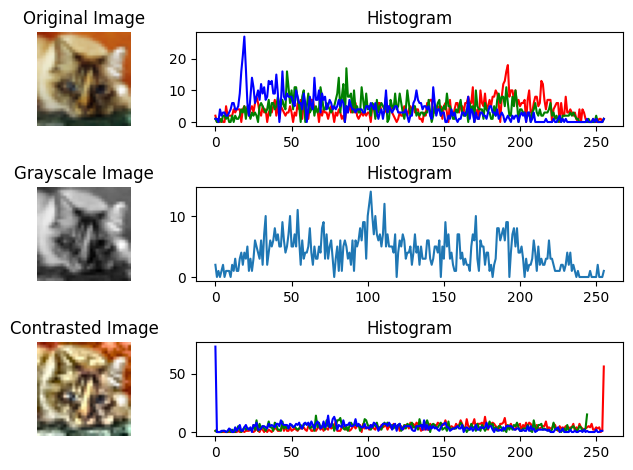

In [7]:
def plot_color_histo_features(image, save_path=None):
    gray_image = rgb2gray(image)

    _, axis = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 3]})
    
    # Grascale Image
    axis[1][0].imshow(gray_image, cmap='gray')
    axis[1][1].set_title('Histogram')
    axis[1][0].set_title('Grayscale Image')
    axis[1][0].axis('off')
    hist = exposure.histogram(gray_image)
    axis[1][1].plot(hist[0])

    # Color image
    if image.ndim == 3:
        axis[0][0].imshow(image, cmap='gray')
        axis[0][1].set_title('Histogram')
        axis[0][0].set_title('Original Image')
        axis[0][0].axis('off')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[0][1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

        contrast_image = contrast((image * 255).astype(np.uint8))

        axis[2][0].imshow(contrast_image, cmap='gray')
        axis[2][1].set_title('Histogram')
        axis[2][0].set_title('Contrasted Image')
        axis[2][0].axis('off')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[2][1].plot(exposure.histogram(contrast_image[...,i])[0], color=mycolor)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# sample_image = X_train[np.random.randint(0, X_train.shape[0])]        
sample_image = X_train[4]

# plot_color_histo_features(sample_image, "../reports/color_histo_features.png")
plot_color_histo_features(sample_image)

#### Plot HOG feature

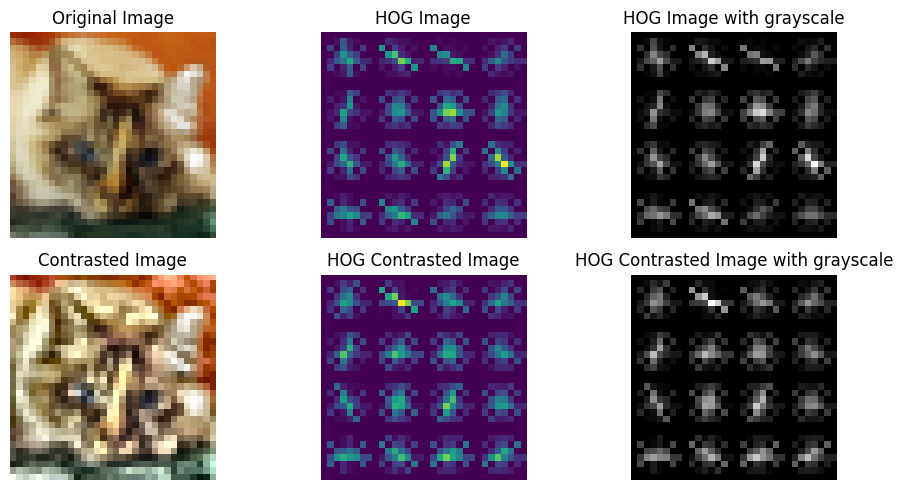

In [8]:
def plot_hog_features(image, save_path=None):
    """
    Plot the HOG features of an image.

    Args:
        image: The image to plot the HOG features.
        save_path: The path to save the plot.
    """
    # Convertir l'image en niveaux de gris
    gray_image = rgb2gray(image)
    contrast_image = contrast((image * 255).astype(np.uint8))
    gray_contrast = rgb2gray(contrast_image)

    # Extraire les caractéristiques HOG de l'image
    normal_hog = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')
    contrast_hog = hog(gray_contrast, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None, block_norm='L2-Hys')

    # Normaliser l'image HOG
    # hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) # L'image est déjà normalisée au préalable
    
    # Afficher l'image originale et l'image HOG
    fig, axs = plt.subplots(2, 3, figsize=(10, 5))
    axs[0][0].imshow(image)
    axs[0][0].set_title('Original Image')
    axs[0][0].axis('off')

    axs[0][1].imshow(normal_hog[1])
    axs[0][1].set_title('HOG Image')
    axs[0][1].axis('off')

    axs[0][2].imshow(normal_hog[1], cmap='gray')
    axs[0][2].set_title('HOG Image with grayscale')
    axs[0][2].axis('off')

    axs[1][0].imshow(contrast_image)
    axs[1][0].set_title('Contrasted Image')
    axs[1][0].axis('off')

    axs[1][1].imshow(contrast_hog[1])
    axs[1][1].set_title('HOG Contrasted Image')
    axs[1][1].axis('off')

    axs[1][2].imshow(contrast_hog[1], cmap='gray')
    axs[1][2].set_title('HOG Contrasted Image with grayscale')
    axs[1][2].axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# sample_image = X_train[np.random.randint(0, X_train.shape[0])]
sample_image = X_train[4]

# plot_hog_features(sample_image, "../reports/hog_features.png")
plot_hog_features(sample_image)

#### Plot SIFT features

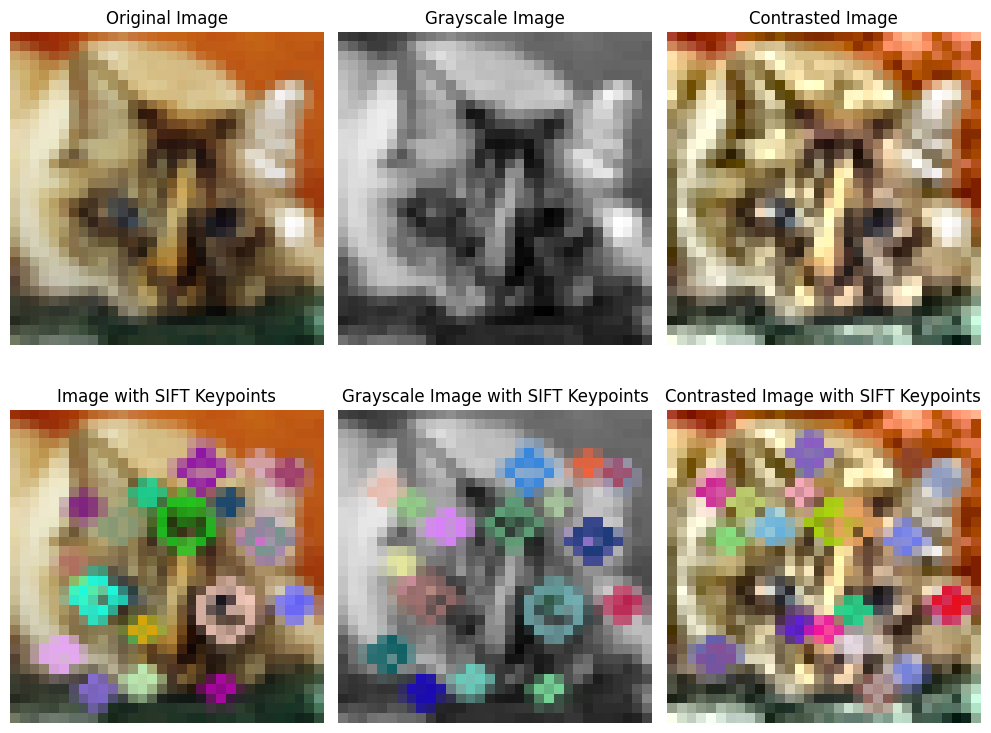

In [9]:
def plot_sift_features(image, save_path=None):
    """
    Plots the original image, grayscale image, keypoints on grayscale image, and final image with keypoints overlaid.
    
    Args:
        image: The input image as a numpy array.
        save_path: The path to save the plot.
    """
    image_8bit = (image * 255).astype(np.uint8)
    gray_image = (rgb2gray(image) * 255).astype(np.uint8)
    image_contrast = (contrast((image * 255).astype(np.uint8)))

    # Initialisation du détecteur de points clés SIFT
    sift = cv2.SIFT_create()
    
    # Détection des points clés et calcul des descripteurs
    key_desc_original = sift.detectAndCompute(image_8bit, None)
    key_desc_gray = sift.detectAndCompute(gray_image, None)
    key_desc_contrast = sift.detectAndCompute(image_contrast, None)

    # Afficher les points clés sur l'image originale
    image_with_keypoints = cv2.drawKeypoints(image_8bit, key_desc_original[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Afficher les points clés sur l'image en niveaux de gris
    gray_image_with_keypoints = cv2.drawKeypoints(gray_image, key_desc_gray[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Afficher les points clés sur l'image contrastée
    contrast_image_with_keypoints = cv2.drawKeypoints(image_contrast, key_desc_contrast[0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Afficher les images: originale, en niveaux de gris, en niveaux de gris avec les points clés, et originale avec les points clés
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))
    
    axs[0][0].imshow(image)
    axs[0][0].set_title('Original Image')
    axs[0][0].axis('off')

    axs[0][1].imshow(gray_image, cmap='gray')
    axs[0][1].set_title('Grayscale Image')
    axs[0][1].axis('off')

    axs[0][2].imshow(image_contrast)
    axs[0][2].set_title('Contrasted Image')
    axs[0][2].axis('off')
        
    axs[1][0].imshow(image_with_keypoints)
    axs[1][0].set_title('Image with SIFT Keypoints')
    axs[1][0].axis('off')
                   
    axs[1][1].imshow(gray_image_with_keypoints)
    axs[1][1].set_title('Grayscale Image with SIFT Keypoints')
    axs[1][1].axis('off')
                   
    axs[1][2].imshow(contrast_image_with_keypoints)
    axs[1][2].set_title('Contrasted Image with SIFT Keypoints')
    axs[1][2].axis('off')    
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# sample_image = X_train[np.random.randint(0, X_train.shape[0])]
sample_image = X_train[4]

# plot_sift_features(sample_image, "../reports/sift_features.png")
plot_sift_features(sample_image)

#### Corner detection

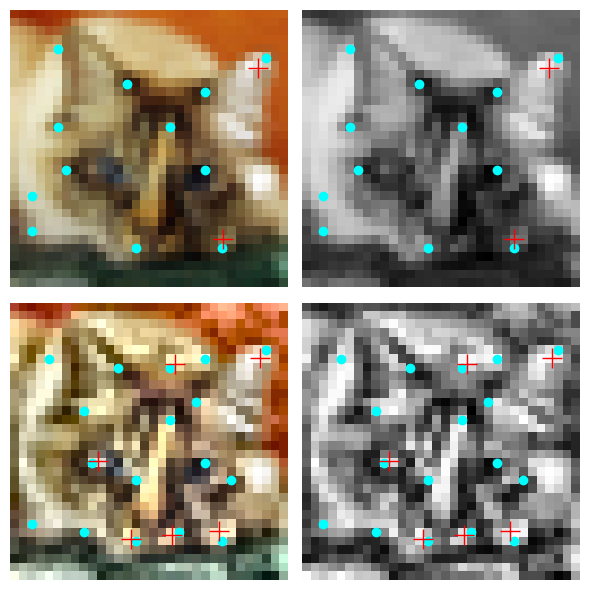

In [10]:
def plot_corner_detect_features(image, save_path=None):
    """
    Plot the corner detection features of an image.

    Args:
        image: The image to plot the corner detection features.
        save_path: The path to save the plot.
    """
    
    gray_image = rgb2gray(image)
    image = (image * 255).astype(np.uint8)

    coords = corner_peaks(corner_harris(gray_image), min_distance=2, threshold_rel=0.01)
    coords_subpix = corner_subpix(gray_image, coords, window_size=4)

    fig, axis = plt.subplots(2, 2, figsize=(6, 6))
    axis[0][0].axis('off')
    axis[0][0].imshow(image)
    axis[0][0].plot(
        coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
    )
    axis[0][0].plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)

    axis[0][1].axis('off')
    axis[0][1].imshow(gray_image, cmap='gray')
    axis[0][1].plot(
        coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
    )
    axis[0][1].plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    
    # ----------- Contrasted Image ------------
    contrasted_image = contrast(image)
    gray_contrasted_image = rgb2gray(contrasted_image)

    coords2 = corner_peaks(corner_harris(gray_contrasted_image), min_distance=2, threshold_rel=0.01)
    coords_subpix2 = corner_subpix(gray_contrasted_image, coords2, window_size=4)

    axis[1][0].axis('off')
    axis[1][0].imshow(contrasted_image)
    axis[1][0].plot(
        coords2[:, 1], coords2[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
    )
    axis[1][0].plot(coords_subpix2[:, 1], coords_subpix2[:, 0], '+r', markersize=15)

    axis[1][1].axis('off')
    axis[1][1].imshow(gray_contrasted_image, cmap='gray')
    axis[1][1].plot(
        coords2[:, 1], coords2[:, 0], color='cyan', marker='o', linestyle='None', markersize=6
    )
    axis[1][1].plot(coords_subpix2[:, 1], coords_subpix2[:, 0], '+r', markersize=15)
    

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# sample_image = X_train[np.random.randint(0, X_train.shape[0])]
sample_image = X_train[4]

# plot_corner_detect_features(sample_image, "../reports/corner_detect_features.png")
plot_corner_detect_features(sample_image)